## Main notebook for the icpe data challenge

#### Import libraries

In [2]:
import bson
import json
import os

#arrays and dataframe
import numpy as np
import pandas as pd

#graphics 
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as pe
import matplotlib.dates as md
from matplotlib.text import Text
# high-level plots
import seaborn as sns

# dealing with dates 
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

# distance (between time series)
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from time import time


### Import data

In [3]:
data_folder = '../mongodb_performance_results/all/'

files = os.listdir(data_folder)

### we download the zenodo repo, unzip all the bson files 
### and put it in the parent directory - see data_folder above
### we then use bsondump to change the bson file to the json format
### see https://docs.mongodb.com/database-tools/bsondump/


### Short description of the files :

### 'em_change_points.json',

# originally in 'expanded_metrics/change_points.bson'
# change_points: Computed change points with annotations.

### 'em_time_series.json'

# originally in 'expanded_metrics/time_series.bson'
# time_series: Performance test results, stored in an array. One document per test measurement.
# The data gathered over time for this time series, 
# with time series being uniquely identified by the combination of 
# project/variant/task/test/measurement/args options. 
# Changing any of those when reporting data causes 
# the data to inserted into another time series.

### 'em_versions.json'

# originally in 'expanded_metrics/versions.bson'
# versions: Information on git versions. 
# denormalized metadata about versions

### 'perf_change_points.json'

# originally in 'perf/change_points.bson'
# change_points: Computed change points

### 'perf_points.json'

# originally in 'perf/points.bson'
# points: The performance results. One document per test result.  

### 'perf_processed_change_points.json'

# originally in 'perf/processed_change_points.bson'
# processed_change_points: Computed change points with human annotations
# This document is the same as in change points, 
# except for the addition of the "processed" field. 
# Objects in the change_points collection were copied 
# to the processed_change_points collection when a person processed the point. 

### 'suspect_points.json'

# originally in the root directory
# 
#data = dict()
#for f_name in files[1:]:
#    print(f_name)
#    with open(data_folder+f_name,'rb') as f:
#        for line in f:
#            test.append(json.loads(line))

#### Import time series

In [ ]:
time_series = dict()
ts_args = dict()

with open(data_folder+'em_time_series.json','r') as json_file:
    for line in json_file.readlines():
        jline = json.loads(line)
        key = (jline["measurement"], jline["project"], jline["task"], jline["test"], jline["variant"], jline["_id"]['$oid'])
        time_series[key] = [(dataline["commit_date"]['$date'],int(dataline["value"])) 
                                 for dataline in jline['data'] if dataline["commit_date"] is not None]
        ts_args[key] = jline["args"]

ts_keys = pd.Series([k[0:5] for k in time_series.keys()]).unique()

len(open('../mongodb_performance_results/all/em_time_series.json','r').readlines())

#### Import change points

In [ ]:
change_points = dict()

with open(data_folder+'em_change_points.json','r') as json_file:
    for line in json_file.readlines():
        jline = json.loads(line)
        jline_cp = jline["time_series_info"]
        key = (jline_cp["measurement"], jline_cp["project"], jline_cp["task"], 
               jline_cp["test"], jline_cp["variant"])
        if key not in change_points:
            change_points[key] = []
        if "commit_date" in jline and "percent_change" in jline and "z_score_change" in jline:
            change_points[key].append((jline["commit_date"]['$date'], 
                                      jline["percent_change"], 
                                      jline["z_score_change"]))
        
cp_keys = [k for k in change_points.keys()]

len(open(data_folder+'em_change_points.json','r').readlines())

#### Some statistics

In [ ]:
measurement = pd.Series([key[0] for key in ts_keys]).unique()
project = pd.Series([key[1] for key in ts_keys]).unique()
task = pd.Series([key[2] for key in ts_keys]).unique()
test = pd.Series([key[3] for key in ts_keys]).unique()
variant = pd.Series([key[4] for key in ts_keys]).unique()

print("measurements", len(measurement))
print("projects", len(project))
print("task",len(task))
print("test",len(test))
print("variants",len(variant))

#### Figure 1

('ss tcmalloc generic current_allocated_bytes (MiB) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-3-node-replSet')


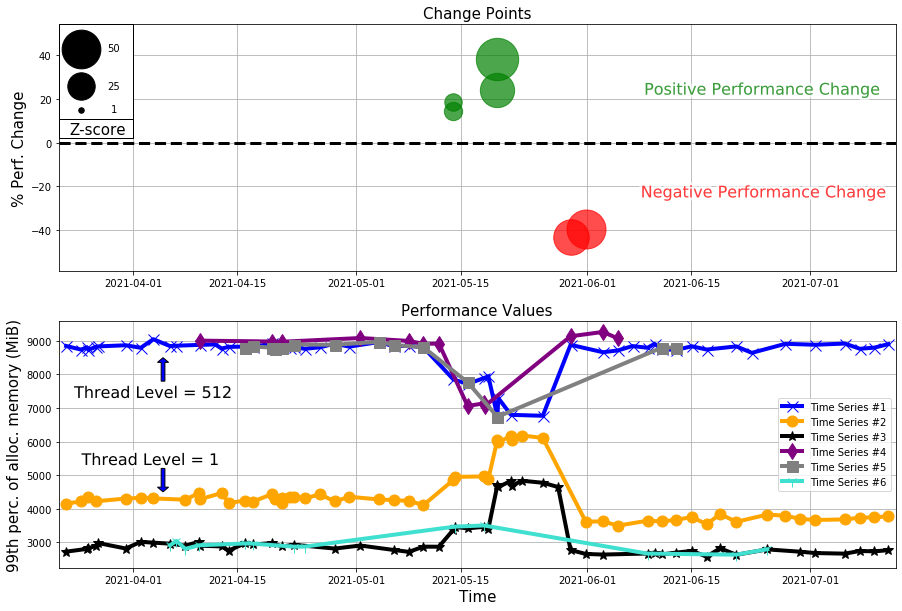

In [7]:
# generation of a random key with enough change points (>5)
tab = [len(change_points[key]) for key in cp_keys if len(change_points[key])>0]

not_found = True

while not_found:
    i = np.random.randint(0, len(tab))
    if tab[i] > 5:
        #if [key for key in cp_keys if len(change_points[key])>0][i][0] != 'ops_per_sec':
        my_special_key = [key for key in cp_keys if len(change_points[key])>0][i]
        not_found = False

# then we focus on this case
my_special_key = ('ss tcmalloc generic current_allocated_bytes (MiB) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-3-node-replSet')
print(my_special_key)

list_all_ts = [key for key in time_series.keys() if key[0:5] == my_special_key]

fig, axs = plt.subplots(2, 1, figsize=((15, 10)))   

min_all_dates = min(([min([k[0] for k in time_series[key]]) for key in list_all_ts]))
max_all_dates = max(([max([k[0] for k in time_series[key]]) for key in list_all_ts]))

# up 

cps = change_points[my_special_key]
dates = [datetime.strptime(cp[0], '%Y-%m-%dT%H:%M:%S.000Z') for cp in cps]
percent_changes = [cp[1] for cp in cps]
z_scores = [np.abs(cp[2]) for cp in cps]

axs[0].grid(zorder = 0)

std_factor = 2

axs[0].set_xlim(datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1), 
                datetime.strptime(max_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=1))
axs[0].set_ylim(min(percent_changes)-np.std(percent_changes)/std_factor,
                max(percent_changes)+np.std(percent_changes)/std_factor)


for i in range(len(dates)):
    if percent_changes[i] > 0:
        axs[0].scatter(dates[i], percent_changes[i], s = int(50*z_scores[i]), 
                       color = "green", alpha =0.7, zorder = 4)
    else:
        axs[0].scatter(dates[i], percent_changes[i], s = int(50*z_scores[i]), 
                       color = "red", alpha =0.7, zorder = 4)
axs[0].get_yaxis().set_major_formatter(ScalarFormatter())
axs[0].set_ylabel("% Perf. Change", size = 15)
axs[0].set_xlabel("", size = 15)
axs[0].set_title("Change Points", size = 15)

axs[0].hlines(0, axs[0].get_xlim()[0], axs[0].get_xlim()[1], linestyles='dashed', linewidth = 3, color='black')

axs[0].text(datetime(2021, 6, 8, 15, 55, 29), 22,"Positive Performance Change", 
            path_effects=[pe.withStroke(linewidth=6, foreground="white")],
            color = "green", size = 16, alpha =0.7, zorder =4)
axs[0].text(datetime(2021, 6, 8, 4, 55, 29), -25,"Negative Performance Change",
            path_effects=[pe.withStroke(linewidth=6, foreground="white")],
            color = "red", size = 16, alpha =0.7, zorder =4)

min_date = datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1)

axs[0].add_patch(pat.Rectangle(
        (min_date, 2),
        relativedelta(days=10),
        axs[0].get_ylim()[1]-2,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

axs[0].add_patch(pat.Rectangle(
        (min_date, 2),
        relativedelta(days=10),
        9,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

axs[0].scatter(min_date+relativedelta(days=3), 15, s = 30, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=7), 14,"1")
axs[0].scatter(min_date+relativedelta(days=3), 26, s =30*25, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=6.5), 24.5,"25")
axs[0].scatter(min_date+relativedelta(days=3), 43, s =30*50, color = "black", zorder =4)
axs[0].text(min_date+relativedelta(days=6.5), 42,"50")
axs[0].text(min_date+relativedelta(days=1.5), 4,"Z-score", size= 15)


# down
axs[1].grid(zorder = 0)

min_all_perf = min(([min([k[1] for k in time_series[key]]) for key in list_all_ts]))
max_all_perf = max(([max([k[1] for k in time_series[key]]) for key in list_all_ts]))

colors = ['blue', 'orange', 'black', 'purple', 'grey', 'turquoise', 'green', 'red']
markers = ["x", "o", "*", "d", "s", "1", "2"]

axs[1].set_xlim(datetime.strptime(min_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=-1), 
                datetime.strptime(max_all_dates, '%Y-%m-%dT%H:%M:%S.000Z')+relativedelta(days=1))


for j in range(len(list_all_ts)):
    
    key = list_all_ts[j]
    jmod7 = j%7

    df = pd.DataFrame(time_series[key], columns = ["date", "perf"])
    df.sort_values(by='date')

    dates = [datetime.strptime(strd, '%Y-%m-%dT%H:%M:%S.000Z') for strd in df['date']]
    
    axs[1].plot(dates, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
                linewidth = 4, label = 'Time Series #'+str(j+1), zorder = 4)

axs[1].legend()

x0 = md.date2num(datetime(2021,4,5))
y0 = 7800
xw = md.date2num(datetime(2021,4,5)) - x0
yw = 700
arr = plt.Arrow(x0, y0, xw, yw, edgecolor='black', width =2.5, zorder =4)
axs[1].add_patch(arr)
arr.set_facecolor('b')

axs[1].text(datetime(2021, 3, 24, 1, 1, 1), 7300, "Thread Level = 512", 
            path_effects=[pe.withStroke(linewidth=6, foreground="white")],
            color = "black", size = 16, zorder =4)

x0 = md.date2num(datetime(2021,4,5))
y0 = 5200
xw = md.date2num(datetime(2021,4,5)) - x0
yw = -700
arr = plt.Arrow(x0, y0, xw, yw, edgecolor='black', width =2.5, zorder =4)
axs[1].add_patch(arr)
arr.set_facecolor('b')

axs[1].text(datetime(2021, 3, 25, 1, 1, 1), 5300, "Thread Level = 1", 
            path_effects=[pe.withStroke(linewidth=6, foreground="white")],
            color = "black", size = 16, zorder =4)

#handles, labels = ax.get_legend_handles_labels()
#p = []
#ax.plot(df.date, df.est, color = colors[i], linewidth = 5, label = sys)
#p.append(mlines.Line2D([], [], color=colors[i], 
#marker= markers[i], markersize=10, linewidth = 5, label=sys_name))
#ax.text(dates[i], vals[i], sys_name, color = colors[i], size = 20, 
#            path_effects=[pe.withStroke(linewidth=6, foreground="white")])
#ax.legend(handles=p)
#ax.set_yscale('log')
#ax.set_yticks([3, 5, 10, 20, 30, 50,100, 150])
#plt.savefig("./results/evolution_perf.png", dpi = 300)

axs[1].get_yaxis().set_major_formatter(ScalarFormatter())
#axs[1].set_ylabel(my_special_key[0], size = 15)
axs[1].set_ylabel("99th perc. of alloc. memory (MiB)", size = 15)
axs[1].set_xlabel("Time", size = 15)
axs[1].set_title("Performance Values", size = 15)
plt.savefig('./results/fig1.png', dpi = 300)
plt.show()

##### Justification of thread levels

In [8]:
[ts_args[key] for key in list_all_ts]

[{'mongod': 2, 'thread_level': 512},
 {'mongod': 0, 'thread_level': 1},
 {'mongod': 2, 'thread_level': 1},
 {'mongod': 0, 'thread_level': 512},
 {'mongod': 1, 'thread_level': 512},
 {'mongod': 1, 'thread_level': 1}]

In [9]:
# same
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'initialsync-large', 'initialsync_large_c_32_d_32_w_t', 'linux-3-node-replSet-initialsync')
# ('Latency95thPercentile', 'sys-perf', 'linkbench2', 'ADD_LINK_ms', 'linux-3-node-replSet')
# ('Latency99thPercentile', 'sys-perf', 'linkbench2', 'DELETE_LINK_ms', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - p99', 'sys-perf-4.4', 'mongos_workloads', 'benchRun', 'linux-3-shard')
# ('ss wt block-manager bytes written (MiB/s) - max', 'sys-perf', 'snapshot_reads', 'benchRun', 'linux-3-node-replSet')
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'mixed_writes_replica', 'mixed_writes_replica', 'linux-1-node-15gbwtcache')
# ('Data - disk xvde disk written (writes/s) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-shard-lite')
# ('ops_per_sec', 'performance', 'misc_custom_filter_default', 'Remove.IntNonIdNoIndex', 'linux-wt-standalone')

# different
# ('Journal - disk xvdf disk written (writes/s) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_95read5update_w_majority', 'linux-shard-lite')
# ('Journal - disk xvdf disk written (writes/s) - mean', 'sys-perf', 'bestbuy_agg_merge_different_db', 'benchRun', 'linux-shard-lite')
# ('ss tcmalloc generic current_allocated_bytes (MiB) - max', 'sys-perf', 'industry_benchmarks_secondary_reads', 'ycsb_95read5update_secondary_reads', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - mean', 'sys-perf', 'industry_benchmarks', 'ycsb_50read50update', 'linux-3-node-replSet')
# ('Journal - disk xvdf disk written (writes/s) - mean', 'sys-perf', 'change_streams_latency', 'change_streams_latency_update_lookup', 'linux-3-node-replSet')
# ('Data - disk xvde utilization (%) - p99', 'sys-perf', 'bestbuy_agg_merge_target_hashed', 'benchRun', 'linux-shard-lite')
#('Journal - disk xvdf utilization (%) - mean', 'sys-perf', 'snapshot_reads', 'benchRun', 'linux-3-node-replSet')
#('ss tcmalloc generic current_allocated_bytes (MiB) - p99', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_50read50update_w_majority', 'linux-3-node-replSet')
#('ss tcmalloc generic current_allocated_bytes (MiB) - max', 'sys-perf', 'industry_benchmarks_wmajority', 'ycsb_95read5update_w_majority', 'linux-shard-lite')


#### Pre-processing of time series

In [4]:
# time series = pd Series indexed by date
# first =  date, second = value
ts1 = [(763, 3), (765, 8), (789, 10), (800, 5)]
ts2 = [(761, 4), (790, 5), (789, 12), (805, 4)]

class Ts2dtw:
    # a class to achieve the pre-processing of the time series
    # and compute the dtw between the pre-processed series
    
    def __init__(self, ts1, ts2):
        # ts1 the first time series, ts2 the second
        self.dates_ts1 = sorted([v[0] for v in ts1])
        self.dates_ts2 = sorted([v[0] for v in ts2])
        
        self.min_date, self.max_date = self.find_min_max_date()
        
        self.valid_period = self.min_date < self.max_date
        
        if self.valid_period:
            self.ts_final = None
            self.ts1 = dict()
            for t in ts1:
                self.ts1[t[0]] = t[1]
            self.ts2 = dict()
            for t in ts2:
                self.ts2[t[0]] = t[1]
            self.dates = self.merge_dates()
            self.build_merge_ts()

    def find_min_max_date(self):
        return (max(min(self.dates_ts1), min(self.dates_ts2)), 
                min(max(self.dates_ts1), max(self.dates_ts2)))
    
    def merge_dates(self):
        dates = [d for d in self.dates_ts2 if d >= self.min_date and d<= self.max_date] 
        dates.extend([d for d in self.dates_ts1 if d >= self.min_date and d<= self.max_date and d not in dates])
        return sorted(dates)
    
    def build_merge_ts(self):
        self.ts_final = dict()
        for d in self.dates:
            inter_ts1 = None
            inter_ts2 = None
            if d in self.ts1.keys():
                inter_ts1 = self.ts1[d]
            else:
                inter_ts1 = self.interpolate(1, d)
            if d in self.ts2.keys():
                inter_ts2 = self.ts2[d]
            else:
                inter_ts2 = self.interpolate(2, d)
            self.ts_final[d] = (inter_ts1, inter_ts2)

    def find_two_neighbors(self, tab, val):
        # WARNING : tab should be sorted
        # returns the two values before and after val
        n1 = None
        n2 = None
        n2_found = False
        for i in range(len(tab)):
            if tab[i] < val:
                n1 = tab[i]
            if tab[i] > val and not n2_found:
                n2 = tab[i]
                n2_found = True
        return (n1, n2)
    
    def interpolate(self, ts_id, d):
        # interpolate the value of time series with the id ts_id at the date d
        
        interpol_val = None
        neighbors = None
        
        if ts_id == 1:
            n1, n2 = self.find_two_neighbors(self.dates_ts1, d)
            variation = (self.ts1[n2] - self.ts1[n1])/(n2-n1)
            interpol_val = self.ts1[n1]+(d-n1)*variation
        else:
            n1, n2 = self.find_two_neighbors(self.dates_ts2, d)
            variation = (self.ts2[n2] - self.ts2[n1])/(n2-n1)
            interpol_val = self.ts2[n1]+(d-n1)*variation
        
        return interpol_val
    
    def compute_dtw(self):
        return dtw.distance([self.ts_final[k][0] for k in self.ts_final.keys()], 
                            [self.ts_final[k][1] for k in self.ts_final.keys()])
        
ts = Ts2dtw(ts1, ts2)
ts.compute_dtw()

4.593679450516622

##### dtw between TS #1, TS#2 and TS #3

In [14]:
tss = dict()

for i in range(3):

    key = list_all_ts[i]

    df = pd.DataFrame(time_series[key], columns = ["date", "perf"])
    df.sort_values(by='date')
    
    dates = [int(datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.000Z').timestamp()) for d in df.date]
    
    perfs = [(p-np.mean(df.perf))/np.std(df.perf)for p in df.perf]

    tss[i] = [(dates[j], perfs[j]) for j in range(df.shape[0])]

ts = Ts2dtw(tss[0], tss[1])
print("1 & 2", ts.compute_dtw())

ts = Ts2dtw(tss[1], tss[2])
print("2 & 3", ts.compute_dtw())

ts = Ts2dtw(tss[2], tss[2])
print("3 & 3", ts.compute_dtw())

NameError: name 'list_all_ts' is not defined

### Figure 2

#### Import points - Dataset perf

In [6]:
perf_points = dict()

with open(data_folder+'perf_points.json','r') as json_file:
    for line in json_file.readlines():
        jline = json.loads(line)
        key = (jline["project"], jline["task"], 
               jline["test"], jline["variant"], jline["workload"])
        tab = [r["ops_per_sec"] for r in jline["results"] 
               if "ops_per_sec" in r and r["thread_level"]=="1"]
        if key not in perf_points:
            perf_points[key] = []
        if "create_time" in jline and len(tab)>0:
            perf_points[key].append((datetime.strptime(jline["create_time"][0:19], '%Y-%m-%dT%H:%M:%S').timestamp(),
                                     tab[0]))

perf_keys_inter = [k for k in perf_points.keys()]

for key in perf_keys_inter:
    # we suppress the time series with one point value or less
    if len(perf_points[key])<2:
        del perf_points[key]
    else:
        dates = [p[0] for p in perf_points[key] if type(p[1]) != dict]
        values = [p[1] for p in perf_points[key] if type(p[1]) != dict]
        std_values = [(v-np.mean(values))/np.std(values) 
                      if np.std(values) > 1e-4 else v/np.mean(values) 
                      for v in values]
        perf_points[key] = [(dates[i], std_values[i]) for i in range(len(dates))]

perf_keys = [k for k in perf_points.keys()]

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
project = pd.Series([key[0] for key in perf_keys]).unique()
task = pd.Series([key[1] for key in perf_keys]).unique()
test = pd.Series([key[2] for key in perf_keys]).unique()
variant = pd.Series([key[3] for key in perf_keys]).unique()
workload = pd.Series([key[4] for key in perf_keys]).unique()

print("workloads", len(workload))
print("projects", len(project))
print("task", len(task))
print("test", len(test))
print("variants", len(variant))

workloads 22
projects 18
task 156
test 1079
variants 63


In [9]:
e = time()

a = []
s = 0
for i in range(5000):
    (i0, j0) = np.random.randint(0, 500, 2)
    ts = Ts2dtw(perf_points[perf_keys[i0]], perf_points[perf_keys[j0]])
    if ts.valid_period:
        s+=1
        a.append(ts.compute_dtw())
d = time()
print(d-e, s, np.mean(a))

12.903523683547974 1973 5.016325969824778


In [31]:
res = dict()

for i in range(len(variant)):
    for j in range(i, len(variant)):
        v1 = variant[i]
        v2 = variant[j]
        res[v1, v2] = []
        if v1 != v2:
            # for each pair of distinct workloads
            pks1 = [(pk[0], pk[1], pk[2], pk[4]) for pk in perf_keys if pk[3] == v1]
            pks2 = [(pk[0], pk[1], pk[2], pk[4]) for pk in perf_keys if pk[3] == v2]
            interpk = [pk for pk in pks1 if pk in pks2]
            print(v1, v2, len(interpk))
            for pk in interpk:
                pk1 = (pk[0], pk[1], pk[2], v1, pk[3])
                pk2 = (pk[0], pk[1], pk[2], v2, pk[3])
                if len(perf_points[pk1]) > 0 and len(perf_points[pk2]) > 0:
                    ts = Ts2dtw(perf_points[pk1], 
                                perf_points[pk2])
                    if ts.valid_period:
                        val = ts.compute_dtw()
                        res[v1, v2].append(val)

linux-3-shard linux-1-node-replSet 1332
linux-3-shard wtdevelop-shard-lite 254
linux-3-shard linux-replSet-initialsync-logkeeper 0
linux-3-shard linux-standalone 1059
linux-3-shard wtdevelop-3-node-replSet 762
linux-3-shard wtdevelop-standalone 579
linux-3-shard linux-3-node-replSet 1406
linux-3-shard linux-3-node-replSet-initialsync 0
linux-3-shard wtdevelop-1-node-replSet 734
linux-3-shard linux-shard-lite 929
linux-3-shard mmap-3-node-replSet 453
linux-3-shard mmap-1-node-replSet 403
linux-3-shard mmap-standalone 403
linux-3-shard mmap-3-shard 620
linux-3-shard mmap-3-node-replSet-initialsync 0
linux-3-shard linux-wt-repl 0
linux-3-shard linux-wt-standalone 0
linux-3-shard linux-standalone-audit 188
linux-3-shard linux-mmap-repl 0
linux-3-shard linux-mmap-standalone 0
linux-3-shard linux-wt-shard 0
linux-3-shard M60-atlas-repl 0
linux-3-shard M30-atlas-repl 0
linux-3-shard linux-3-node-replSet-ssl 126
linux-3-shard linux-1-node-replSet-ese-cbc 67
linux-3-shard linux-1-node-replSet-e

linux-replSet-initialsync-logkeeper M80-atlas-NVME-repl 0
linux-replSet-initialsync-logkeeper M200-atlas-repl 0
linux-replSet-initialsync-logkeeper M60-atlas-NVME-repl 0
linux-replSet-initialsync-logkeeper M100-atlas-repl 0
linux-replSet-initialsync-logkeeper M200-atlas-NVME-repl 0
linux-replSet-initialsync-logkeeper linux-3-node-replSet-flowcontrol 0
linux-replSet-initialsync-logkeeper M50-nvme-atlas-repl 0
linux-replSet-initialsync-logkeeper M10-atlas-repl 0
linux-replSet-initialsync-logkeeper M300-atlas-repl 0
linux-replSet-initialsync-logkeeper M400-atlas-NVME-repl 0
linux-replSet-initialsync-logkeeper R40-atlas-repl 0
linux-replSet-initialsync-logkeeper R80-atlas-repl 0
linux-replSet-initialsync-logkeeper atlas-like-M60 0
linux-replSet-initialsync-logkeeper linux-3-node-replSet-noflowcontrol 0
linux-replSet-initialsync-logkeeper linux-1-node-15gbwtcache 0
linux-replSet-initialsync-logkeeper M40-nvme-atlas-repl 0
linux-replSet-initialsync-logkeeper M40-atlas-repl 0
linux-replSet-in

wtdevelop-standalone M50-atlas-repl 0
wtdevelop-standalone R200-atlas-repl 0
wtdevelop-standalone R60-atlas-repl 0
wtdevelop-standalone M80-atlas-NVME-repl 0
wtdevelop-standalone M200-atlas-repl 0
wtdevelop-standalone M60-atlas-NVME-repl 0
wtdevelop-standalone M100-atlas-repl 0
wtdevelop-standalone M200-atlas-NVME-repl 0
wtdevelop-standalone linux-3-node-replSet-flowcontrol 71
wtdevelop-standalone M50-nvme-atlas-repl 0
wtdevelop-standalone M10-atlas-repl 0
wtdevelop-standalone M300-atlas-repl 0
wtdevelop-standalone M400-atlas-NVME-repl 0
wtdevelop-standalone R40-atlas-repl 0
wtdevelop-standalone R80-atlas-repl 0
wtdevelop-standalone atlas-like-M60 962
wtdevelop-standalone linux-3-node-replSet-noflowcontrol 251
wtdevelop-standalone linux-1-node-15gbwtcache 66
wtdevelop-standalone M40-nvme-atlas-repl 0
wtdevelop-standalone M40-atlas-repl 0
wtdevelop-standalone M20-atlas-repl 0
wtdevelop-standalone R400-atlas-repl 0
wtdevelop-standalone R50-atlas-repl 0
wtdevelop-standalone linux-1-node-r

wtdevelop-1-node-replSet M50-nvme-atlas-repl 0
wtdevelop-1-node-replSet M10-atlas-repl 0
wtdevelop-1-node-replSet M300-atlas-repl 0
wtdevelop-1-node-replSet M400-atlas-NVME-repl 0
wtdevelop-1-node-replSet R40-atlas-repl 0
wtdevelop-1-node-replSet R80-atlas-repl 0
wtdevelop-1-node-replSet atlas-like-M60 1189
wtdevelop-1-node-replSet linux-3-node-replSet-noflowcontrol 569
wtdevelop-1-node-replSet linux-1-node-15gbwtcache 66
wtdevelop-1-node-replSet M40-nvme-atlas-repl 0
wtdevelop-1-node-replSet M40-atlas-repl 0
wtdevelop-1-node-replSet M20-atlas-repl 0
wtdevelop-1-node-replSet R400-atlas-repl 0
wtdevelop-1-node-replSet R50-atlas-repl 0
wtdevelop-1-node-replSet linux-1-node-replSet-fle 58
wtdevelop-1-node-replSet linux-1-node-replSet-cwrwc 58
wtdevelop-1-node-replSet linux-shard-lite-cwrwc 58
wtdevelop-1-node-replSet linux-replSet-auth-delay 0
wtdevelop-1-node-replSet linux-3-node-1dayhistory-15gbwtcache 74
wtdevelop-1-node-replSet linux-3-node-replSet-last-continuous-fcv 391
wtdevelop-1-

mmap-standalone linux-mmap-repl 0
mmap-standalone linux-mmap-standalone 0
mmap-standalone linux-wt-shard 0
mmap-standalone M60-atlas-repl 0
mmap-standalone M30-atlas-repl 0
mmap-standalone linux-3-node-replSet-ssl 0
mmap-standalone linux-1-node-replSet-ese-cbc 0
mmap-standalone linux-1-node-replSet-ese-gcm 0
mmap-standalone M50-atlas-repl 0
mmap-standalone R200-atlas-repl 0
mmap-standalone R60-atlas-repl 0
mmap-standalone M80-atlas-NVME-repl 0
mmap-standalone M200-atlas-repl 0
mmap-standalone M60-atlas-NVME-repl 0
mmap-standalone M100-atlas-repl 0
mmap-standalone M200-atlas-NVME-repl 0
mmap-standalone linux-3-node-replSet-flowcontrol 0
mmap-standalone M50-nvme-atlas-repl 0
mmap-standalone M10-atlas-repl 0
mmap-standalone M300-atlas-repl 0
mmap-standalone M400-atlas-NVME-repl 0
mmap-standalone R40-atlas-repl 0
mmap-standalone R80-atlas-repl 0
mmap-standalone atlas-like-M60 0
mmap-standalone linux-3-node-replSet-noflowcontrol 0
mmap-standalone linux-1-node-15gbwtcache 0
mmap-standalone M

linux-wt-standalone linux-3-node-replSet-flowcontrol 0
linux-wt-standalone M50-nvme-atlas-repl 0
linux-wt-standalone M10-atlas-repl 0
linux-wt-standalone M300-atlas-repl 0
linux-wt-standalone M400-atlas-NVME-repl 0
linux-wt-standalone R40-atlas-repl 0
linux-wt-standalone R80-atlas-repl 0
linux-wt-standalone atlas-like-M60 0
linux-wt-standalone linux-3-node-replSet-noflowcontrol 0
linux-wt-standalone linux-1-node-15gbwtcache 0
linux-wt-standalone M40-nvme-atlas-repl 0
linux-wt-standalone M40-atlas-repl 0
linux-wt-standalone M20-atlas-repl 0
linux-wt-standalone R400-atlas-repl 0
linux-wt-standalone R50-atlas-repl 0
linux-wt-standalone linux-1-node-replSet-fle 0
linux-wt-standalone linux-1-node-replSet-cwrwc 0
linux-wt-standalone linux-shard-lite-cwrwc 0
linux-wt-standalone linux-replSet-auth-delay 0
linux-wt-standalone linux-3-node-1dayhistory-15gbwtcache 0
linux-wt-standalone linux-3-node-replSet-last-continuous-fcv 0
linux-wt-standalone linux-3-node-replSet-last-lts-fcv 0
linux-wt-stan

M60-atlas-repl atlas-like-M60 0
M60-atlas-repl linux-3-node-replSet-noflowcontrol 0
M60-atlas-repl linux-1-node-15gbwtcache 0
M60-atlas-repl M40-nvme-atlas-repl 31
M60-atlas-repl M40-atlas-repl 54
M60-atlas-repl M20-atlas-repl 37
M60-atlas-repl R400-atlas-repl 31
M60-atlas-repl R50-atlas-repl 22
M60-atlas-repl linux-1-node-replSet-fle 0
M60-atlas-repl linux-1-node-replSet-cwrwc 0
M60-atlas-repl linux-shard-lite-cwrwc 0
M60-atlas-repl linux-replSet-auth-delay 0
M60-atlas-repl linux-3-node-1dayhistory-15gbwtcache 0
M60-atlas-repl linux-3-node-replSet-last-continuous-fcv 0
M60-atlas-repl linux-3-node-replSet-last-lts-fcv 0
M60-atlas-repl linux-3-node-replSet-disabled-feature-flags 0
M60-atlas-repl linux-replSet-audit 0
M60-atlas-repl linux-shard-lite-all-feature-flags 0
M60-atlas-repl linux-shard-single 0
M60-atlas-repl linux-3-node-replSet-maintenance-events 0
M60-atlas-repl linux-shard-lite-audit 0
M30-atlas-repl linux-3-node-replSet-ssl 0
M30-atlas-repl linux-1-node-replSet-ese-cbc 0
M

M50-atlas-repl atlas-like-M60 0
M50-atlas-repl linux-3-node-replSet-noflowcontrol 0
M50-atlas-repl linux-1-node-15gbwtcache 0
M50-atlas-repl M40-nvme-atlas-repl 31
M50-atlas-repl M40-atlas-repl 54
M50-atlas-repl M20-atlas-repl 37
M50-atlas-repl R400-atlas-repl 31
M50-atlas-repl R50-atlas-repl 22
M50-atlas-repl linux-1-node-replSet-fle 0
M50-atlas-repl linux-1-node-replSet-cwrwc 0
M50-atlas-repl linux-shard-lite-cwrwc 0
M50-atlas-repl linux-replSet-auth-delay 0
M50-atlas-repl linux-3-node-1dayhistory-15gbwtcache 0
M50-atlas-repl linux-3-node-replSet-last-continuous-fcv 0
M50-atlas-repl linux-3-node-replSet-last-lts-fcv 0
M50-atlas-repl linux-3-node-replSet-disabled-feature-flags 0
M50-atlas-repl linux-replSet-audit 0
M50-atlas-repl linux-shard-lite-all-feature-flags 0
M50-atlas-repl linux-shard-single 0
M50-atlas-repl linux-3-node-replSet-maintenance-events 0
M50-atlas-repl linux-shard-lite-audit 0
R200-atlas-repl R60-atlas-repl 38
R200-atlas-repl M80-atlas-NVME-repl 57
R200-atlas-repl 

M100-atlas-repl R50-atlas-repl 0
M100-atlas-repl linux-1-node-replSet-fle 0
M100-atlas-repl linux-1-node-replSet-cwrwc 0
M100-atlas-repl linux-shard-lite-cwrwc 0
M100-atlas-repl linux-replSet-auth-delay 0
M100-atlas-repl linux-3-node-1dayhistory-15gbwtcache 0
M100-atlas-repl linux-3-node-replSet-last-continuous-fcv 0
M100-atlas-repl linux-3-node-replSet-last-lts-fcv 0
M100-atlas-repl linux-3-node-replSet-disabled-feature-flags 0
M100-atlas-repl linux-replSet-audit 0
M100-atlas-repl linux-shard-lite-all-feature-flags 0
M100-atlas-repl linux-shard-single 0
M100-atlas-repl linux-3-node-replSet-maintenance-events 0
M100-atlas-repl linux-shard-lite-audit 0
M200-atlas-NVME-repl linux-3-node-replSet-flowcontrol 0
M200-atlas-NVME-repl M50-nvme-atlas-repl 64
M200-atlas-NVME-repl M10-atlas-repl 39
M200-atlas-NVME-repl M300-atlas-repl 66
M200-atlas-NVME-repl M400-atlas-NVME-repl 10
M200-atlas-NVME-repl R40-atlas-repl 51
M200-atlas-NVME-repl R80-atlas-repl 49
M200-atlas-NVME-repl atlas-like-M60 0


R80-atlas-repl linux-3-node-replSet-noflowcontrol 0
R80-atlas-repl linux-1-node-15gbwtcache 0
R80-atlas-repl M40-nvme-atlas-repl 31
R80-atlas-repl M40-atlas-repl 49
R80-atlas-repl M20-atlas-repl 32
R80-atlas-repl R400-atlas-repl 26
R80-atlas-repl R50-atlas-repl 22
R80-atlas-repl linux-1-node-replSet-fle 0
R80-atlas-repl linux-1-node-replSet-cwrwc 0
R80-atlas-repl linux-shard-lite-cwrwc 0
R80-atlas-repl linux-replSet-auth-delay 0
R80-atlas-repl linux-3-node-1dayhistory-15gbwtcache 0
R80-atlas-repl linux-3-node-replSet-last-continuous-fcv 0
R80-atlas-repl linux-3-node-replSet-last-lts-fcv 0
R80-atlas-repl linux-3-node-replSet-disabled-feature-flags 0
R80-atlas-repl linux-replSet-audit 0
R80-atlas-repl linux-shard-lite-all-feature-flags 0
R80-atlas-repl linux-shard-single 0
R80-atlas-repl linux-3-node-replSet-maintenance-events 0
R80-atlas-repl linux-shard-lite-audit 0
atlas-like-M60 linux-3-node-replSet-noflowcontrol 600
atlas-like-M60 linux-1-node-15gbwtcache 42
atlas-like-M60 M40-nvme-

linux-1-node-replSet-cwrwc linux-replSet-auth-delay 0
linux-1-node-replSet-cwrwc linux-3-node-1dayhistory-15gbwtcache 0
linux-1-node-replSet-cwrwc linux-3-node-replSet-last-continuous-fcv 48
linux-1-node-replSet-cwrwc linux-3-node-replSet-last-lts-fcv 48
linux-1-node-replSet-cwrwc linux-3-node-replSet-disabled-feature-flags 48
linux-1-node-replSet-cwrwc linux-replSet-audit 17
linux-1-node-replSet-cwrwc linux-shard-lite-all-feature-flags 0
linux-1-node-replSet-cwrwc linux-shard-single 0
linux-1-node-replSet-cwrwc linux-3-node-replSet-maintenance-events 0
linux-1-node-replSet-cwrwc linux-shard-lite-audit 10
linux-shard-lite-cwrwc linux-replSet-auth-delay 0
linux-shard-lite-cwrwc linux-3-node-1dayhistory-15gbwtcache 0
linux-shard-lite-cwrwc linux-3-node-replSet-last-continuous-fcv 48
linux-shard-lite-cwrwc linux-3-node-replSet-last-lts-fcv 48
linux-shard-lite-cwrwc linux-3-node-replSet-disabled-feature-flags 48
linux-shard-lite-cwrwc linux-replSet-audit 17
linux-shard-lite-cwrwc linux-sha

In [39]:
dtws

array([[-1.        ,  7.4569698 ,  4.63430216, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        ,  5.17098236, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

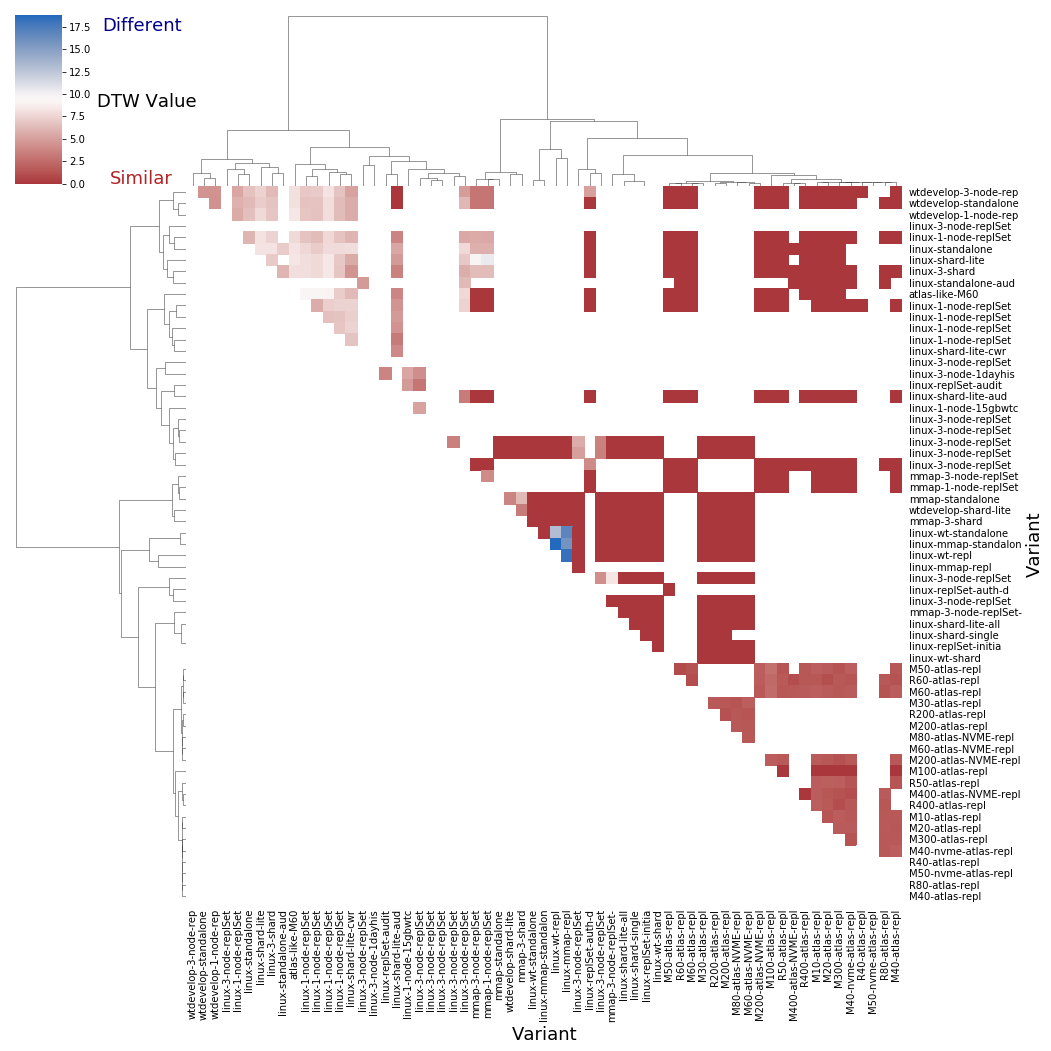

In [295]:

dtws = -1*np.ones(len(variant)*len(variant)).reshape(len(variant),len(variant))
for i in range(len(variant)):
    for j in range(i, len(variant)):
        v1 = variant[i]
        v2 = variant[j]
        if len(res[v1, v2]) > 5:
            val = np.mean(res[v1,v2])
            dtws[i,j] = val
            dtws[j,i] = val
            
# we transform our matrix into a dataframe
df = pd.DataFrame(dtws)
# we replace nan correlations (with a distribution whose values are all equal to 0)
df = df.fillna(0)

# group the videos, we choose the ward method 
# single link method (minimum of distance) leads to numerous tiny clusters
# centroid or average tend to split homogeneous clusters
# and complete link aggregates unbalanced groups. 
links = linkage(df, method="ward",)
order = leaves_list(links)

# Generate a mask for the upper triangle
# we order the correlation following the aggregation clustering
mask = np.zeros_like(dtws, dtype=np.bool)

#fig = plt.figure(figsize = (20,20))
for i in range(len(variant)):
    for j in range(len(variant)):    
        if i>j or dtws[i,j] == -1:
            mask[order[i]][order[j]] = True

# compute the actual clustermap
g = sns.clustermap(df, cmap="vlag_r", mask=mask, method="ward",
               linewidths=0, figsize=(13, 13), 
               #cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
               vmin =0, xticklabels=True, yticklabels=True)
tab = [t.get_text() for t in g.ax_heatmap.get_yticklabels()]
tab_position = [t.get_position() for t in g.ax_heatmap.get_yticklabels()]
new_labs = [Text(0, 0, variant[int(t)][0:20]) for t in tab]
for i in range(len(tab)):
    nl = new_labs[i]
    nl.set_position(tab_position[i])
g.ax_heatmap.set_yticklabels(new_labs, rotation=0, fontsize = 10)
tab = [t.get_text() for t in g.ax_heatmap.get_xticklabels()]
tab_position = [t.get_position() for t in g.ax_heatmap.get_xticklabels()]
new_labs = [Text(0, 0, variant[int(t)][0:20]) for t in tab]
for i in range(len(tab)):
    nl = new_labs[i]
    nl.set_position(tab_position[i])
g.ax_heatmap.set_xticklabels(new_labs, rotation=90, fontsize = 10)
g.ax_heatmap.tick_params(right=False, bottom=False)
# abcissa and ordered labels
g.ax_heatmap.set_xlabel("Variant", fontsize = 18)
g.ax_heatmap.set_ylabel("Variant", fontsize = 18)
plt.text(33, 8.5, "DTW Value", fontsize = 18)
plt.text(35, 17, "Different", fontsize = 18, color="darkblue")
plt.text(38, 0, "Similar", fontsize = 18, color="firebrick")
# we save the figure in the result folder
#plt.tight_layout(pad=1)
plt.savefig("./results/fig2a.png", dpi = 300, bbox_inches='tight', pad_inches=0.5)
# we show the graph
plt.show()

1 :  ('sys-perf-atlas', 'genny_smoke', 'nop_real_avg_latency_picoseconds', 'M40-atlas-repl', 'genny_canaries')
2 :  ('sys-perf', 'non_sharded_workloads', 'canary_client-cpuloop-10x', 'wtdevelop-standalone', 'cpu_noise')
3 :  ('60a42baed6d80a60143d4ad6', 'snapshot_reads', 'snapshot_reads_with_load', 'linux-1-node-replSet', 'mongoshell')
4 :  ('performance-3.6', 'update', 'Update.DocValidation.TwentyNum', 'linux-wt-repl', 'microbenchmarks')


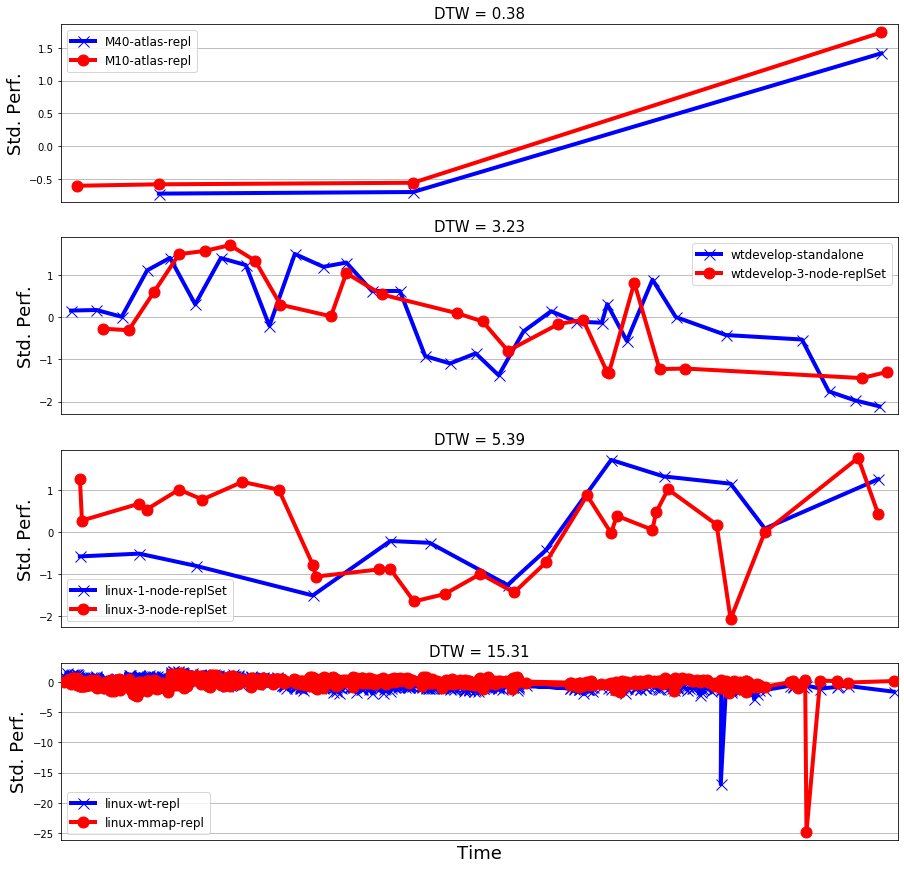

In [298]:
fig, axs = plt.subplots(4, 1, figsize=((15, 15)))  

delay = 1000000

# top
val1 = 'M40-atlas-repl'
val2 = 'M10-atlas-repl'

my_special_keys = [(v[0], v[1], v[2], v[3], v[4]) for v in perf_keys if v[3] == val1 
                   and (v[0], v[1], v[2], val2, v[4]) in perf_keys]

val = np.random.randint(0, len(my_special_keys))
my_special_key1 = ('sys-perf-atlas', 'genny_smoke', 
                   'nop_real_avg_latency_picoseconds', 'M40-atlas-repl', 'genny_canaries')
my_special_key2 = (my_special_key1[0], my_special_key1[1], my_special_key1[2], 
                   val2, my_special_key1[4])
print("1 : ", my_special_key1)

min_all_dates = min(min([k[0] for k in perf_points[my_special_key1]]), 
                    min([k[0] for k in perf_points[my_special_key2]]))
max_all_dates = max(max([k[0] for k in perf_points[my_special_key1]]), 
                    max([k[0] for k in perf_points[my_special_key2]]))

axs[0].grid(zorder = 0)

axs[0].set_xlim(min_all_dates-delay/2, max_all_dates+delay/2)

jmod7 = 0
df = pd.DataFrame(perf_points[my_special_key1], columns = ["date", "perf"])
df.sort_values(by='date')
axs[0].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key1[3], zorder = 4)

jmod7 = 1
df = pd.DataFrame(perf_points[my_special_key2], columns = ["date", "perf"])
df.sort_values(by='date')
axs[0].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key2[3], zorder = 4)



axs[0].legend(fontsize=12)

axs[0].set_xticks([])
#axs[0].set_ylabel(my_special_key[0], size = 15)
axs[0].set_ylabel("Std. Perf.", size = 18)
#axs[0].set_xlabel("Time", size = 15)
ts = Ts2dtw(perf_points[my_special_key1], perf_points[my_special_key2])
axs[0].set_title("DTW = "+str(np.round(ts.compute_dtw(),2)), size = 15)

# middle top

val1 = 'wtdevelop-standalone'
val2 = 'wtdevelop-3-node-replSet'

my_special_keys = [(v[0], v[1], v[2], v[3], v[4]) for v in perf_keys if v[3] == val1 
                   and (v[0], v[1], v[2], val2, v[4]) in perf_keys]

val = np.random.randint(0, len(my_special_keys))
my_special_key1 = ('sys-perf', 'non_sharded_workloads', 'canary_client-cpuloop-10x', 'wtdevelop-standalone', 'cpu_noise')
my_special_key2 = (my_special_key1[0], my_special_key1[1], my_special_key1[2], 
                   val2, my_special_key1[4])
print("2 : ", my_special_key1)

min_all_dates = min(min([k[0] for k in perf_points[my_special_key1]]), 
                    min([k[0] for k in perf_points[my_special_key2]]))
max_all_dates = max(max([k[0] for k in perf_points[my_special_key1]]), 
                    max([k[0] for k in perf_points[my_special_key2]]))

axs[1].grid(zorder = 0)

axs[1].set_xlim(min_all_dates-delay/4, max_all_dates+delay/4)

jmod7 = 0
df = pd.DataFrame(perf_points[my_special_key1], columns = ["date", "perf"])
df.sort_values(by='date')
axs[1].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key1[3], zorder = 4)

jmod7 = 1
df = pd.DataFrame(perf_points[my_special_key2], columns = ["date", "perf"])
df.sort_values(by='date')
axs[1].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key2[3], zorder = 4)



axs[1].legend(fontsize=12)

axs[1].get_yaxis().set_major_formatter(ScalarFormatter())
#axs[1].set_ylabel(my_special_key[0], size = 15)
axs[1].set_xticks([])
axs[1].set_ylabel("Std. Perf.", size = 18)
#axs[1].set_xlabel("Time", size = 15)
ts = Ts2dtw(perf_points[my_special_key1], perf_points[my_special_key2])
axs[1].set_title("DTW = "+str(np.round(ts.compute_dtw(),2)), size = 15)

# middle down

val1 = 'linux-1-node-replSet'
val2 = 'linux-3-node-replSet'

my_special_keys = [(v[0], v[1], v[2], v[3], v[4]) for v in perf_keys if v[3] == val1 
                   and (v[0], v[1], v[2], val2, v[4]) in perf_keys]

val = np.random.randint(0, len(my_special_keys))
my_special_key1 = ('60a42baed6d80a60143d4ad6', 'snapshot_reads', 
                   'snapshot_reads_with_load', 'linux-1-node-replSet', 'mongoshell')

my_special_key2 = (my_special_key1[0], my_special_key1[1], my_special_key1[2], 
                   val2, my_special_key1[4])
print("3 : ", my_special_key1)

min_all_dates = min(min([k[0] for k in perf_points[my_special_key1]]), 
                    min([k[0] for k in perf_points[my_special_key2]]))
max_all_dates = max(max([k[0] for k in perf_points[my_special_key1]]), 
                    max([k[0] for k in perf_points[my_special_key2]]))

axs[2].grid(zorder = 0)

axs[2].set_xlim(min_all_dates-delay/10, max_all_dates+delay/10)

jmod7 = 0
df = pd.DataFrame(perf_points[my_special_key1], columns = ["date", "perf"])
df.sort_values(by='date')
axs[2].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key1[3], zorder = 4)

jmod7 = 1
df = pd.DataFrame(perf_points[my_special_key2], columns = ["date", "perf"])
df.sort_values(by='date')
axs[2].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key2[3], zorder = 4)



axs[2].legend(fontsize=12)

axs[2].set_xticks([])
#axs[2].set_ylabel(my_special_key[0], size = 15)
axs[2].set_ylabel("Std. Perf.", size = 18)
ts = Ts2dtw(perf_points[my_special_key1], perf_points[my_special_key2])
axs[2].set_title("DTW = "+str(np.round(ts.compute_dtw(),2)), size = 15)

# down
val1 = 'linux-wt-repl'
val2 = 'linux-mmap-repl'

my_special_keys = [(v[0], v[1], v[2], v[3], v[4]) for v in perf_keys if v[3] == val1 
                   and (v[0], v[1], v[2], val2, v[4]) in perf_keys]

val = np.random.randint(0, len(my_special_keys))
my_special_key1 = ('performance-3.6', 'update', 'Update.DocValidation.TwentyNum', 'linux-wt-repl', 'microbenchmarks')
my_special_key2 = (my_special_key1[0], my_special_key1[1], my_special_key1[2], 
                   val2, my_special_key1[4])
print("4 : ", my_special_key1)

min_all_dates = min(min([k[0] for k in perf_points[my_special_key1]]), 
                    min([k[0] for k in perf_points[my_special_key2]]))
max_all_dates = max(max([k[0] for k in perf_points[my_special_key1]]), 
                    max([k[0] for k in perf_points[my_special_key2]]))

axs[3].grid(zorder = 0)

axs[3].set_xlim(min_all_dates-delay/2, max_all_dates+delay/2)

jmod7 = 0
df = pd.DataFrame(perf_points[my_special_key1], columns = ["date", "perf"])
df.sort_values(by='date')
axs[3].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key1[3], zorder = 4)

jmod7 = 1
df = pd.DataFrame(perf_points[my_special_key2], columns = ["date", "perf"])
df.sort_values(by='date')
axs[3].plot(df.date, df.perf, color = colors[jmod7], marker= markers[jmod7], markersize=11, 
            linewidth = 4, label = my_special_key2[3], zorder = 4)



axs[3].legend(fontsize=12)

axs[3].set_xticks([])
#axs[3].set_ylabel(my_special_key[0], size = 15)
axs[3].set_ylabel("Std. Perf.", size = 18)
#axs[3].set_xlabel("Time", size = 15)
ts = Ts2dtw(perf_points[my_special_key1], perf_points[my_special_key2])
axs[3].set_title("DTW = "+str(np.round(ts.compute_dtw(),2)), size = 15)
axs[3].set_xlabel("Time", size = 18)


plt.savefig('./results/fig2b.png', dpi = 300)
plt.show()

In [ ]:
# ('performance-3.4', 'update', 'Update.DocValidation.TenNum', 'linux-mmap-repl', 'microbenchmarks')
# ('performance-3.4', 'misc', 'Remove.IntNonIdIndex', 'linux-mmap-repl', 'microbenchmarks')
# ('performance-3.4', 'insert', 'Insert.DocValidation.OneFiftyInt', 'linux-wt-repl', 'microbenchmarks')

# moderate
# ('sys-perf-4.4', 'misc_workloads', 'fio_latency_test_write_clat_mean', 'wtdevelop-3-node-replSet', 'fio')

# Strange
# ('sys-perf', 'mixed_workloads', 'canary_server-cpuloop-10x', 'wtdevelop-3-node-replSet', 'mongoshell')

# ('performance-4.0', 'insert', 'Insert.SingleIndex.Contested.Rnd', 'linux-wt-repl', 'microbenchmarks')

In [303]:
pd.Series([k[0] for k in dtws.reshape(-1,1) if k !=-1]).describe()

count    1138.000000
mean        4.436281
std         2.677402
min         0.979711
25%         1.700018
50%         4.484802
75%         6.426653
max        18.802687
dtype: float64

### Figure 3

In [304]:
perf_points[perf_keys[0]]

[(1492251920.0, 0.6990483226505911),
 (1492343118.0, 1.086685366675681),
 (1492933456.0, -0.02409581441958679),
 (1493467845.0, 0.08535710820585776),
 (1494027396.0, 0.883793557958657),
 (1494675168.0, 0.898149110462219),
 (1495296119.0, -0.44957061102760465),
 (1495626535.0, -0.7924204612925577),
 (1495876112.0, 0.33067978666183373),
 (1496434697.0, 0.5824260534610999),
 (1496773296.0, -2.4085481335637238),
 (1496777258.0, 0.0721557765645796),
 (1498230166.0, -0.4287529771064541),
 (1498258462.0, -0.8562854959686022),
 (1498517109.0, -0.5898954352225488),
 (1498928910.0, 1.2738739395196117),
 (1499535632.0, 1.505216113453208),
 (1499893795.0, -1.869873827203582),
 (1500134083.0, 0.0020576201913116436)]

In [85]:
tab[0]#.set_text(variant[int(tab[0].get_text())])

'5'

In [154]:
perf_points[perf_keys[0]]

[(1492251920.0, 0.6990483226505911),
 (1492343118.0, 1.086685366675681),
 (1492933456.0, -0.02409581441958679),
 (1493467845.0, 0.08535710820585776),
 (1494027396.0, 0.883793557958657),
 (1494675168.0, 0.898149110462219),
 (1495296119.0, -0.44957061102760465),
 (1495626535.0, -0.7924204612925577),
 (1495876112.0, 0.33067978666183373),
 (1496434697.0, 0.5824260534610999),
 (1496773296.0, -2.4085481335637238),
 (1496777258.0, 0.0721557765645796),
 (1498230166.0, -0.4287529771064541),
 (1498258462.0, -0.8562854959686022),
 (1498517109.0, -0.5898954352225488),
 (1498928910.0, 1.2738739395196117),
 (1499535632.0, 1.505216113453208),
 (1499893795.0, -1.869873827203582),
 (1500134083.0, 0.0020576201913116436)]